## Type of Best Restaurant Classifier

In [1]:
# Importing neceessary libraries
from bs4 import BeautifulSoup # BeautifulSoup class for scraping websites
import requests # requests library for sending GET requests
import pandas as pd # for creating dataframes
import numpy as np # for computations
import matplotlib.pyplot as plt

In [2]:
# Sending a GET request to 'https://worldpostalcode.com/france/ile-de-france/paris'
url = 'https://worldpostalcode.com/france/ile-de-france/paris'
response = requests.get(url)

In [3]:
# Getting out the required data
complete_soup = BeautifulSoup(response.content, 'html.parser') # parsing the content recieved from website

# try-except block for catching any error that may arise in future due to website changes
try:
    paris_all_postal_codes = []
    # finding all the spans inside of parent div with class code
    code_div = complete_soup.find('div', 'code')
    for span in code_div.find_all('span'): 
        paris_all_postal_codes.append(span.text) # geeting only the text part of sapn tag 
except error:
    print(error)

In [4]:
# installing folium and geopy
!pip install folium==0.5.0
!pip install geopy

from geopy.geocoders import Nominatim # for obtaining coordiantes (latitude, longitude) based on address
import folium # for plotting maps

pd.set_option('display.max_columns', None) # for displaying all columns
pd.set_option('display.max_rows', None) # for displaying all rows

import json # for handling json response
from pandas.io.json import json_normalize # for flattening json
import matplotlib.cm as cm
import matplotlib.colors as colors

# importing Kmeans for making clusters
from sklearn.cluster import KMeans

print('All imports done!')

All imports done!


In [5]:
def get_coordinates_using_nominatim(place, missing_flag = False):
    """
    function that uses Nominatim server to get location coordinates based on address
    """
    latitude = 'NA'
    longitude = 'NA'
    if missing_flag==False:
        place_complete_name = f'{place}, Paris, France'
    else:
        place_complete_name = place
        
    geolocator = Nominatim(user_agent='paris-explorer')
    location_coordinates = geolocator.geocode(place_complete_name)
    if(location_coordinates != None):
        latitude = location_coordinates.latitude
        longitude = location_coordinates.longitude
    return [latitude, longitude]

In [6]:
# Making a dictionary for postal codes and corresponding coordinates using Nominatim server
paris_all_location_coordinates = {}
for postal_code in paris_all_postal_codes:
    paris_all_location_coordinates[postal_code] = get_coordinates_using_nominatim(postal_code)

# Creating a dataframe from the results
paris_df = pd.DataFrame(paris_all_location_coordinates).transpose().reset_index()
paris_df.columns = ['Postal Code','Latitude', 'Longitude']
paris_df.head() # Checking head of dataframe

,Postal Code,Latitude,Longitude
0,75000,48.852921,2.345716
1,75001,48.865575,2.331444
2,75002,48.867524,2.343927
3,75003,48.864286,2.359562
4,75004,48.856161,2.357096


In [7]:
# Paris coordinates from google maps
paris_latitude = 48.8566
paris_longitude = 2.3522

In [8]:
# Creating Paris map using folium's Map class and starting with initial zoom of 12
complete_paris_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

# Putting markers on map for highlighting various postal code locations in Paris
for lat, lng, postal_code in zip(paris_df['Latitude'], paris_df['Longitude'], paris_df['Postal Code']):
    label = f'{postal_code}, Paris'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(complete_paris_map) # Adding markers to the above created Map
    
# Displaying the map
complete_paris_map

In [9]:
# The code was removed by Watson Studio for sharing.

In [10]:
# Briefly analyzing the flow for first postal code i.e. 75000 and then it can be scaled up to cover all other postal codes
first_postal_code = paris_df.loc[0,'Postal Code']
first_latitude = paris_df.loc[0, 'Latitude']
first_longitude = paris_df.loc[0, 'Longitude']

print(f'{first_latitude}, {first_longitude}, {first_postal_code}')

48.8529212, 2.345716, 75000


In [11]:
# Category id for only analyzing food outlets
category_id = '4d4b7105d754a06374d81259'
# URL for exploring a particular postal code
url = f'https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&ll={first_latitude},{first_longitude}&v={VERSION}&limit={LIMIT}&categoryId={category_id}'


In [12]:
# Send a GET request using requests API
results = requests.get(url).json()
# Uncomment below line for checking results
# results

In [13]:
def get_category_type(row):
    """
    function that extracts the category of the venue
    """
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
# Extracting venues from JSON response
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON for easier analysis

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns i.e keep only the last part of column name
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
# Check head of the cleaned dataframe
nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng
0,Shiso Burger,Burger Joint,48.853376,2.345302
1,Sourire Tapas Françaises,Tapas Restaurant,48.851167,2.347728
2,Le Petit Châtelet,French Restaurant,48.852637,2.346919
3,Loubnane,Lebanese Restaurant,48.851237,2.347605
4,Sola,Japanese Restaurant,48.851569,2.348391


In [15]:
# Check shape of nearby venues datframe
nearby_venues.shape

(89, 4)

In [16]:
# Applying filter for only selecting restaurants, since our analysis revolves around restaurants
filtered_df_restaurant = nearby_venues[nearby_venues['categories'].apply(lambda x: 'restaurant' in x.lower())]
filtered_df_restaurant.reset_index(drop=True, inplace=True)
filtered_df_restaurant.head()

,name,categories,lat,lng
0,Sourire Tapas Françaises,Tapas Restaurant,48.851167,2.347728
1,Le Petit Châtelet,French Restaurant,48.852637,2.346919
2,Loubnane,Lebanese Restaurant,48.851237,2.347605
3,Sola,Japanese Restaurant,48.851569,2.348391
4,Chez Le Libanais,Lebanese Restaurant,48.853285,2.341673


In [17]:
# !pip install seaborn
import seaborn as sns
sns.set_style('ticks')

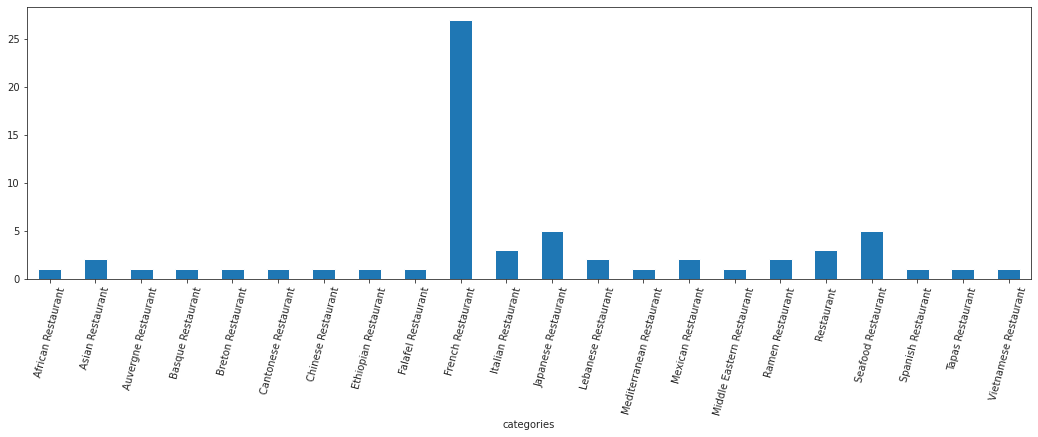

In [18]:
# plotting bar plot for various categories of food outlets for postal code 75000
filtered_df_restaurant.groupby(['categories'])['categories'].count().plot(kind='bar', figsize=(18,5), rot = 75)

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, category_id = '4d4b7105d754a06374d81259'):
    """
    Function to get nearby venues based on name, latitude, longtitude radius and category id
    """
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={LIMIT}&categoryId={category_id}'
            
        # make the GET request and extract only the list of venues
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
# Getting neraby venues for food category
paris_venues = getNearbyVenues(paris_df['Postal Code'], paris_df['Latitude'], paris_df['Longitude'])
paris_venues.head()

,Postal Code,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,75000,48.852921,2.345716,Shiso Burger,48.853376,2.345302,Burger Joint
1,75000,48.852921,2.345716,Sourire Tapas Françaises,48.851167,2.347728,Tapas Restaurant
2,75000,48.852921,2.345716,Le Petit Châtelet,48.852637,2.346919,French Restaurant
3,75000,48.852921,2.345716,Loubnane,48.851237,2.347605,Lebanese Restaurant
4,75000,48.852921,2.345716,Chez Le Libanais,48.853285,2.341673,Lebanese Restaurant


In [21]:
# Filtering out restaurants
filtered_df_restaurant = paris_venues[paris_venues['Venue Category'].apply(lambda x: 'restaurant' in x.lower())]
filtered_df_restaurant.reset_index(drop=True, inplace=True)
filtered_df_restaurant.head()

,Postal Code,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,75000,48.852921,2.345716,Sourire Tapas Françaises,48.851167,2.347728,Tapas Restaurant
1,75000,48.852921,2.345716,Le Petit Châtelet,48.852637,2.346919,French Restaurant
2,75000,48.852921,2.345716,Loubnane,48.851237,2.347605,Lebanese Restaurant
3,75000,48.852921,2.345716,Chez Le Libanais,48.853285,2.341673,Lebanese Restaurant
4,75000,48.852921,2.345716,Sola,48.851569,2.348391,Japanese Restaurant


In [22]:
# Grouping by postal code and venue category for better visualization
paris_group_by = filtered_df_restaurant.groupby(by = ['Postal Code', 'Venue Category']).count()
paris_group_by.head()

Area Latitude  Area Longitude  Venue  \
Postal Code Venue Category                                              
75000       African Restaurant               1               1      1   
            Alsatian Restaurant              1               1      1   
            Asian Restaurant                 2               2      2   
            Auvergne Restaurant              1               1      1   
            Basque Restaurant                1               1      1   

                                 Venue Latitude  Venue Longitude  
Postal Code Venue Category                                        
75000       African Restaurant                1                1  
            Alsatian Restaurant               1                1  
            Asian Restaurant                  2                2  
            Auvergne Restaurant               1                1  
            Basque Restaurant                 1                1

In [23]:
# one hot encoding
paris_venues_onehot = pd.get_dummies(filtered_df_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_venues_onehot['Postal Code'] = filtered_df_restaurant['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [paris_venues_onehot.columns[-1]] + list(paris_venues_onehot.columns[:-1])
paris_venues_onehot = paris_venues_onehot[fixed_columns]
# Check head of the one hot encoded venues dataframe
paris_venues_onehot.head()

,Postal Code,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Basque Restaurant,Brazilian Restaurant,Breton Restaurant,Burgundian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Corsican Restaurant,Doner Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Provençal Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Savoyard Restaurant,Scandinavian Restaurant,Seafood Restaurant,Southwestern French Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,75000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# Group venues by postal codes and calculating mean
paris_grouped = paris_venues_onehot.groupby('Postal Code').mean().reset_index()
paris_grouped.head()

,Postal Code,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Basque Restaurant,Brazilian Restaurant,Breton Restaurant,Burgundian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Corsican Restaurant,Doner Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Okonomiyaki Restaurant,Persian Restaurant,Peruvian Restaurant,Portuguese Restaurant,Provençal Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Savoyard Restaurant,Scandinavian Restaurant,Seafood Restaurant,Southwestern French Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,75000,0.013333,0.013333,0.000000,0.0,0.000000,0.026667,0.013333,0.013333,0.0,0.013333,0.000000,0.0,0.0,0.013333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.013333,0.013333,0.000000,0.360000,0.000000,0.013333,0.0,0.0,0.000000,0.000000,0.080000,0.093333,0.000000,0.0,0.0,0.000000,0.0,0.026667,0.013333,0.040000,0.013333,0.013333,0.0,0.000000,0.013333,0.000000,0.0,0.000000,0.026667,0.000000,0.013333,0.040000,0.000000,0.000000,0.0,0.000000,0.080000,0.0,0.000000,0.000000,0.000000,0.026667,0.000000,0.0,0.000000,0.000000,0.0,0.013333
1,75001,0.000000,0.000000,0.000000,0.0,0.000000,0.046154,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.015385,0.0,0.000000,0.0,0.0,0.000000,0.015385,0.000000,0.000000,0.000000,0.430769,0.000000,0.000000,0.0,0.0,0.015385,0.015385,0.076923,0.076923,0.000000,0.0,0.0,0.046154,0.0,0.000000,0.000000,0.015385,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.061538,0.046154,0.000000,0.015385,0.0,0.015385,0.000000,0.0,0.015385,0.015385,0.000000,0.000000,0.015385,0.0,0.030769,0.015385,0.0,0.015385
2,75002,0.014085,0.000000,0.014085,0.0,0.014085,0.014085,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.042254,0.0,0.014085,0.0,0.0,0.014085,0.014085,0.000000,0.000000,0.014085,0.352113,0.000000,0.014085,0.0,0.0,0.014085,0.000000,0.112676,0.112676,0.000000,0.0,0.0,0.028169,0.0,0.000000,0.000000,0.028169,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.014085,0.000000,0.000000,0.014085,0.042254,0.014085,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.028169,0.000000,0.014085,0.028169,0.0,0.028169,0.000000,0.0,0.000000
3,75003,0.000000,0.018182,0.000000,0.0,0.018182,0.018182,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.054545,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.018182,0.000000,0.254545,0.018182,0.018182,0.0,0.0,0.000000,0.018182,0.090909,0.054545,0.000000,0.0,0.0,0.036364,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.018182,0.000000,0.018182,0.0,0.000000,0.018182,0.000000,0.000000,0.127273,0.000000,0.000000,0.0,0.018182,0.072727,0.0,0.000000,0.018182,0.018182,0.000000,0.018182,0.0,0.000000,0.018182,0.0,0.036364
4,75004,0.000000,0.013889,0.000000,0.0,0.000000,0.013889,0.013889,0.000000,0.0,0.000000,0.013889,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.027778,0.000000,0.444444,0.013889,0.000000,0.0,0.0,0.000000,0.013889,0.083333,0.055556,0.013889,0.0,0.0,0.000000,0.0,0.013889,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.013889

In [25]:
# Print top 5 venues of a paticular postal code and their frequency
num_top_venues = 5

for area in paris_grouped['Postal Code']:
    print("----"+area+"----")
    temp = paris_grouped[paris_grouped['Postal Code'] == area].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----75000----
                 venue  freq
0    French Restaurant  0.36
1  Japanese Restaurant  0.09
2   Seafood Restaurant  0.08
3   Italian Restaurant  0.08
4           Restaurant  0.04


----75001----
                 venue  freq
0    French Restaurant  0.43
1  Japanese Restaurant  0.08
2   Italian Restaurant  0.08
3     Ramen Restaurant  0.06
4           Restaurant  0.05


----75002----
                 venue  freq
0    French Restaurant  0.35
1  Japanese Restaurant  0.11
2   Italian Restaurant  0.11
3           Restaurant  0.04
4   Chinese Restaurant  0.04


----75003----
                 venue  freq
0    French Restaurant  0.25
1           Restaurant  0.13
2   Italian Restaurant  0.09
3   Seafood Restaurant  0.07
4  Japanese Restaurant  0.05


----75004----
                 venue  freq
0    French Restaurant  0.44
1   Italian Restaurant  0.08
2     Tapas Restaurant  0.06
3  Japanese Restaurant  0.06
4           Restaurant  0.04


----75005----
                 venue  freq
0    Fr

In [26]:
def return_most_common_venues(row, num_top_venues):
    """
    function to return most common venues of a particular postal code
    """
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

# 1st, 2nd, 3rd
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
paris_venues_sorted = pd.DataFrame(columns=columns)
paris_venues_sorted['Postal Code'] = paris_grouped['Postal Code']

for ind in range(paris_grouped.shape[0]):
    paris_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

paris_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75000,French Restaurant,Japanese Restaurant,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Portuguese Restaurant,Tapas Restaurant,Lebanese Restaurant
1,75001,French Restaurant,Italian Restaurant,Japanese Restaurant,Ramen Restaurant,Korean Restaurant,Asian Restaurant,Restaurant,Udon Restaurant,Russian Restaurant,Indonesian Restaurant
2,75002,French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Korean Restaurant,Sushi Restaurant,Thai Restaurant,Udon Restaurant
3,75003,French Restaurant,Restaurant,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Israeli Restaurant,Falafel Restaurant
4,75004,French Restaurant,Italian Restaurant,Tapas Restaurant,Japanese Restaurant,Restaurant,Thai Restaurant,Falafel Restaurant,Seafood Restaurant,Scandinavian Restaurant,Israeli Restaurant


In [28]:
response = requests.get('https://www.touropia.com/tourist-attractions-in-paris/')

In [29]:
complete_soup = BeautifulSoup(response.content, 'html.parser')
places_of_attraction_in_paris = []
try:
    for top_title in complete_soup.find_all('span', 'toptitle'):
        places_of_attraction_in_paris.append(top_title.text)
except error:
    print(error)

In [30]:
# Making a dictionary for postal codes and corresponding coordinates using Nominatim server
places_of_attraction_in_paris_coordinates = {}
for place in places_of_attraction_in_paris:
    places_of_attraction_in_paris_coordinates[place] = get_coordinates_using_nominatim(place)
    

missing_places_coordinate = []
for k, v in places_of_attraction_in_paris_coordinates.items():
    if 'NA' in v:
        missing_places_coordinate.append(k)

missing_places_coordinate

['Disneyland Paris', 'Seine Cruise']

In [31]:
manually_corrected_entries = ['Disneyland, France', 'Seine, France']

for i, item in enumerate(manually_corrected_entries):
    places_of_attraction_in_paris_coordinates[missing_places_coordinate[i]] = get_coordinates_using_nominatim(item, True)

In [32]:
# Creating a dataframe from the results
places_of_attraction_df = pd.DataFrame(places_of_attraction_in_paris_coordinates).transpose().reset_index()
places_of_attraction_df.columns = ['Tourist Location', 'Latitude', 'Longitude']
places_of_attraction_df.head() # Checking head of dataframe

,Tourist Location,Latitude,Longitude
0,Place des Vosges,48.855619,2.365542
1,Moulin Rouge,48.884079,2.332408
2,Conciergerie,48.855949,2.346026
3,Pantheon,48.846191,2.346079
4,Pere Lachaise Cemetery,48.861217,2.393929


In [77]:
def calculating_factor_from_25_major_attractions(places_of_attraction, paris_places_df):
    """
    calculating distance from 25 topmost Paris destinations, from a partiular postal code
    """
    ks = []
    for row1 in paris_places_df.iterrows():
        for row2, rank in  zip(places_of_attraction.iterrows(), range(25,0,-1)):
            k = 0
            k += (((row2[1]['Latitude']-row1[1]['Latitude'])**2 + (row2[1]['Longitude']-row1[1]['Longitude'])**2)**0.5)
        ks.append(1/k)
    return ks

In [78]:
paris_df.drop('Tourist Factor', inplace=True, axis = 1)
paris_df['Tourist Factor'] = calculating_factor_from_25_major_attractions(places_of_attraction_df, paris_df)

In [79]:
paris_df.head()

,Postal Code,Latitude,Longitude,Tourist Factor
0,75000,48.852921,2.345716,19.419561
1,75001,48.865575,2.331444,26.552045
2,75002,48.867524,2.343927,19.885370
3,75003,48.864286,2.359562,15.304112
4,75004,48.856161,2.357096,15.966241


In [36]:
# Creating Paris map using folium's Map class and starting with initial zoom of 12
complete_paris_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

# Putting markers on map for highlighting various postal code locations in Paris
for lat, lng, postal_code, pos in zip(places_of_attraction_df['Latitude'], places_of_attraction_df['Longitude'], places_of_attraction_df['Tourist Location'], range(25,0,-1)):
    label = f'{pos}. {postal_code}'
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='red', icon='star')
    ).add_to(complete_paris_map) # Adding markers to the above created Map
    
color_map = np.linspace(paris_df['Tourist Factor'].min(), paris_df['Tourist Factor'].max(), len(paris_df))

# ys = [i + x + (i*x)**2 for i in np.arange(kclusters)]
# colors_array = cm.rainbow(viridis(np.linspace(0,1,len(paris_df))))
# viridis = cm.get_cmap('viridis', 12)
# rainbow = [colors.rgb2hex(i) for i in colors_array]
    
for lat, lng, postal_code, c in zip(paris_df['Latitude'], paris_df['Longitude'], paris_df['Postal Code'], color_map):
    label = f'{postal_code}, Paris'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(complete_paris_map) # Adding markers to the above created Map
    
# Displaying the map
complete_paris_map

In [37]:
paris_grouped_clustering = paris_grouped.drop('Postal Code', 1)

In [38]:
from scipy.spatial.distance import cdist
distortions = []
inertias = []
n_clusters_to_be_tried = range(1,10)
for n in n_clusters_to_be_tried: 
    kmeanModel = KMeans(n_clusters=n, random_state=0).fit(paris_grouped_clustering)    
      
    distortions.append(sum(np.min(cdist(paris_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / paris_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

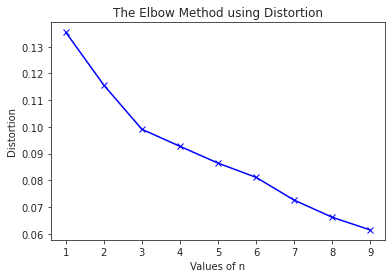

In [39]:
plt.plot(n_clusters_to_be_tried, distortions, 'bx-') 
plt.xlabel('Values of n') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

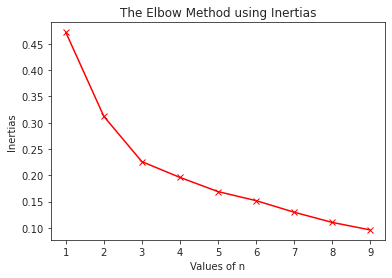

In [40]:
plt.plot(n_clusters_to_be_tried, inertias, 'rx-') 
plt.xlabel('Values of n') 
plt.ylabel('Inertias') 
plt.title('The Elbow Method using Inertias') 
plt.show() 

In [41]:
# set number of clusters
kclusters = 3

# paris_grouped_clustering = paris_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 1, 1, 2, 1, 1, 2, 2, 2], dtype=int32)

In [42]:
# add clustering labels
paris_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# to add latitude, longitude and postal code in the new dataframe
paris_merged_new = paris_df

# merge two dataframes to add most common venues to newly created dataframe 
paris_merged_new = paris_merged_new.join(paris_venues_sorted.set_index('Postal Code'), on='Postal Code')

paris_merged_new.head() # check the first columns!

,Postal Code,Latitude,Longitude,Tourist Factor,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75000,48.852921,2.345716,19.419561,1,French Restaurant,Japanese Restaurant,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Portuguese Restaurant,Tapas Restaurant,Lebanese Restaurant
1,75001,48.865575,2.331444,26.552045,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Ramen Restaurant,Korean Restaurant,Asian Restaurant,Restaurant,Udon Restaurant,Russian Restaurant,Indonesian Restaurant
2,75002,48.867524,2.343927,19.885370,1,French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Korean Restaurant,Sushi Restaurant,Thai Restaurant,Udon Restaurant
3,75003,48.864286,2.359562,15.304112,1,French Restaurant,Restaurant,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Israeli Restaurant,Falafel Restaurant
4,75004,48.856161,2.357096,15.966241,2,French Restaurant,Italian Restaurant,Tapas Restaurant,Japanese Restaurant,Restaurant,Thai Restaurant,Falafel Restaurant,Seafood Restaurant,Scandinavian Restaurant,Israeli Restaurant


In [43]:
# create map
map_clusters = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

# set color scheme for the clusters
x = range(kclusters)
ys = [i + x + (i*x)**2 for i in np.arange(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged_new['Latitude'], paris_merged_new['Longitude'], paris_merged_new['Postal Code'], paris_merged_new['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [44]:
# Looking at first cluster
first_cluster = paris_merged_new[paris_merged_new['Cluster Labels']==0]
first_cluster.reset_index(drop = True, inplace = True)
first_cluster

,Postal Code,Latitude,Longitude,Tourist Factor,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75013,48.829384,2.362013,13.618461,0,Vietnamese Restaurant,Thai Restaurant,French Restaurant,Asian Restaurant,Chinese Restaurant,Italian Restaurant,Japanese Restaurant,Cambodian Restaurant,Restaurant,Cantonese Restaurant


In [45]:
# Looking at second cluster
second_cluster = paris_merged_new[paris_merged_new['Cluster Labels']==1]
second_cluster.reset_index(drop = True, inplace = True)
second_cluster

,Postal Code,Latitude,Longitude,Tourist Factor,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75000,48.852921,2.345716,19.419561,1,French Restaurant,Japanese Restaurant,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Restaurant,Asian Restaurant,Portuguese Restaurant,Tapas Restaurant,Lebanese Restaurant
1,75002,48.867524,2.343927,19.885370,1,French Restaurant,Japanese Restaurant,Italian Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Korean Restaurant,Sushi Restaurant,Thai Restaurant,Udon Restaurant
2,75003,48.864286,2.359562,15.304112,1,French Restaurant,Restaurant,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,Israeli Restaurant,Falafel Restaurant
3,75005,48.846095,2.348502,18.064931,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Lebanese Restaurant,Mexican Restaurant,Seafood Restaurant,Tapas Restaurant,Greek Restaurant,Vietnamese Restaurant,Sushi Restaurant
4,75006,48.852813,2.342799,20.573331,1,French Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Lebanese Restaurant,Restaurant,Asian Restaurant,Tapas Restaurant,Ramen Restaurant
5,75010,48.874166,2.349639,17.425215,1,French Restaurant,Japanese Restaurant,Restaurant,Italian Restaurant,African Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Corsican Restaurant,Empanada Restaurant,Falafel Restaurant
6,75011,48.855630,2.370806,13.097243,1,French Restaurant,Italian Restaurant,Restaurant,Tapas Restaurant,Sushi Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Falafel Restaurant,Korean Restaurant,Japanese Restaurant
7,75012,48.843356,2.386285,10.754028,1,French Restaurant,Italian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Restaurant,Doner Restaurant,Korean Restaurant
8,75015,48.838270,2.295145,49.997183,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Persian Restaurant,Lebanese Restaurant,Restaurant,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant
9,75016,48.853010,2.272351,43.933808,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Restaurant,Thai Restaurant,Asian Restaurant,Korean Restaurant,Seafood Restaurant,Middle Eastern Restaurant,African Restaurant


In [46]:
# Looking at third cluster
third_cluster = paris_merged_new[paris_merged_new['Cluster Labels']==2]
third_cluster.reset_index(drop = True, inplace = True)
third_cluster

,Postal Code,Latitude,Longitude,Tourist Factor,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75001,48.865575,2.331444,26.552045,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Ramen Restaurant,Korean Restaurant,Asian Restaurant,Restaurant,Udon Restaurant,Russian Restaurant,Indonesian Restaurant
1,75004,48.856161,2.357096,15.966241,2,French Restaurant,Italian Restaurant,Tapas Restaurant,Japanese Restaurant,Restaurant,Thai Restaurant,Falafel Restaurant,Seafood Restaurant,Scandinavian Restaurant,Israeli Restaurant
2,75007,48.854757,2.324789,32.795169,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,Restaurant,American Restaurant,Peruvian Restaurant,Gluten-free Restaurant,Korean Restaurant,Lebanese Restaurant
3,75008,48.868720,2.321098,34.987003,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Tapas Restaurant,Asian Restaurant,Corsican Restaurant,Cantonese Restaurant,Restaurant,Indian Restaurant
4,75009,48.878285,2.333977,22.590569,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Vietnamese Restaurant,Sushi Restaurant,Lebanese Restaurant,Argentinian Restaurant,Chinese Restaurant
5,75014,48.830850,2.325736,24.062683,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Sushi Restaurant,Restaurant,Thai Restaurant,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant
6,75017,48.876219,2.289649,53.757572,2,French Restaurant,Italian Restaurant,Seafood Restaurant,Moroccan Restaurant,Breton Restaurant,Thai Restaurant,Sushi Restaurant,Asian Restaurant,Japanese Restaurant,Cantonese Restaurant
7,75018,48.889032,2.343635,17.248449,2,French Restaurant,Italian Restaurant,Restaurant,Seafood Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Japanese Restaurant,American Restaurant
8,75019,48.886679,2.379844,11.117086,2,French Restaurant,Japanese Restaurant,Fast Food Restaurant,Asian Restaurant,Seafood Restaurant,Greek Restaurant,Moroccan Restaurant,Italian Restaurant,Restaurant,Vietnamese Restaurant


In [47]:
# # Looking at fourth cluster
# fourth_cluster = paris_merged_new[paris_merged_new['Cluster Labels']==3]
# fourth_cluster.reset_index(drop = True, inplace = True)
# fourth_cluster

In [48]:
# # Looking at fifth cluster
# fifth_cluster = paris_merged_new[paris_merged_new['Cluster Labels']==4]
# fifth_cluster.reset_index(drop = True, inplace = True)
# fifth_cluster

In [49]:
response = requests.get(r'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/paris.geojson')
data = json.loads(response.text)
# print(data)

In [50]:
name_of_postal_codes = []
for i in range(len(data['features'])):
    name_of_postal_codes.append(data['features'][i]['properties']['name'])

In [80]:
paris_df

,Postal Code,Latitude,Longitude,Tourist Factor
0,75000,48.852921,2.345716,19.419561
1,75001,48.865575,2.331444,26.552045
2,75002,48.867524,2.343927,19.885370
3,75003,48.864286,2.359562,15.304112
4,75004,48.856161,2.357096,15.966241
5,75005,48.846095,2.348502,18.064931
6,75006,48.852813,2.342799,20.573331
7,75007,48.854757,2.324789,32.795169
8,75008,48.868720,2.321098,34.987003
9,75009,48.878285,2.333977,22.590569


In [68]:
tourist_values_dict = {'Bourse': 19.88,'Temple':15.30 ,'Panthéon':18.06 ,'Luxembourg':20.57 ,'Palais-Bourbon':32.79 ,'Élysée':10.75,'Opéra': 22.59,'Popincourt':13.09,'Gobelins':13.61,'Observatoire': 24.06,'Vaugirard': 49.99,
 'Passy': 43.93,'Batignolles-Monceau': 53.75,'Butte-Montmartre': 17.24,'Buttes-Chaumont': 11.11,'Louvre': 26.55,'Hôtel-de-Ville':15.96}
choropleth_df = pd.DataFrame(tourist_values_dict, index=[0]).transpose().reset_index()
choropleth_df.columns = ['Name', 'Tourist']
choropleth_df


# Enclos-St-Laurent - 14
# Reuilly - 12
# Ménilmontant - 11

,Name,Tourist
0,Bourse,19.88
1,Temple,15.30
2,Panthéon,18.06
3,Luxembourg,20.57
4,Palais-Bourbon,32.79
5,Élysée,10.75
6,Opéra,22.59
7,Popincourt,13.09
8,Gobelins,13.61
9,Observatoire,24.06


In [53]:
# Louvre - 1
# Bourse - 2
# Temple - 3
# Hôtel-de-Ville - 4
# Panthéon - 5
# Luxembourg - 6
# Palais-Bourbon - 7

# Opéra - 9

# Popincourt - 11
# Élysée - 12
# Gobelins - 13
# Observatoire - 14
# Vaugirard - 15
# Passy - 16
# Batignolles-Monceau - 17
# Butte-Montmartre - 18
# Buttes-Chaumont - 19



# Enclos-St-Laurent - 14
# Reuilly - 12
# Ménilmontant - 11

In [54]:
# Creating Paris map using folium's Map class and starting with initial zoom of 12
complete_paris_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

# Putting markers on map for highlighting various postal code locations in Paris
for lat, lng, postal_code, pos in zip(places_of_attraction_df['Latitude'], places_of_attraction_df['Longitude'], places_of_attraction_df['Tourist Location'], range(25,0,-1)):
    label = f'{pos}. {postal_code}'
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='red', icon='star')
    ).add_to(complete_paris_map) # Adding markers to the above created Map
    
color_map = np.linspace(paris_df['Tourist Factor'].min(), paris_df['Tourist Factor'].max(), len(paris_df))
    
for lat, lng, postal_code, c in zip(paris_df['Latitude'], paris_df['Longitude'], paris_df['Postal Code'], color_map):
    label = f'{postal_code}, Paris'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(complete_paris_map) # Adding markers to the above created Map
    
# Displaying the map
complete_paris_map

In [69]:
# file name - file is located in the working directory
# communities_geo = r'spain-communities.geojson' # geojson file

# create a plain world map
communities_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12, tiles='stamenwatercolor')

# generate choropleth map 
communities_map.choropleth(
    geo_data=data,
    data=choropleth_df,
    columns=['Name','Tourist'],
    key_on='feature.properties.name',
    fill_color='YlGnBu', 
    fill_opacity=1, 
    line_opacity=1,
    legend_name='Births per 1000 inhabitants',
    smooth_factor=0)


# Putting markers on map for highlighting various postal code locations in Paris
for lat, lng, postal_code, pos in zip(places_of_attraction_df['Latitude'], places_of_attraction_df['Longitude'], places_of_attraction_df['Tourist Location'], range(25,0,-1)):
    label = f'{pos}. {postal_code}'
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='red', icon='star')
    ).add_to(communities_map) # Adding markers to the above created Map
    
color_map = np.linspace(paris_df['Tourist Factor'].min(), paris_df['Tourist Factor'].max(), len(paris_df))

# ys = [i + x + (i*x)**2 for i in np.arange(kclusters)]
# colors_array = cm.rainbow(viridis(np.linspace(0,1,len(paris_df))))
# viridis = cm.get_cmap('viridis', 12)
# rainbow = [colors.rgb2hex(i) for i in colors_array]
    
for lat, lng, postal_code, c in zip(paris_df['Latitude'], paris_df['Longitude'], paris_df['Postal Code'], color_map):
    label = f'{postal_code}, Paris'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(communities_map) # Adding markers to the above created Map

# display map
communities_map